# 15.457 - Advanced Analytics of Finance
# Hackathon
# Anastasia Demina, Elina Harutyunyan

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import acf 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error as mse
import math as m
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso

In [48]:
stocks = pd.read_csv("/Users/elinaharutyunyan/Desktop/MFin Spring 2020/Advanced Analytics of Finance/Hackathon/Training/StockReturns.csv")
factors = pd.read_csv("/Users/elinaharutyunyan/Desktop/MFin Spring 2020/Advanced Analytics of Finance/Hackathon/Training/Factors.csv")
stocks.date = pd.to_datetime(stocks.date, format = '%Y%m',errors = 'ignore')
stocks.set_index('date',inplace = True)
factors.date = pd.to_datetime(factors.date, format = '%Y%m',errors = 'ignore')
factors.set_index('date',inplace = True)
#print(stocks.head(5))
#print(factors.head(5))

In [49]:
stocks = stocks/100
factors = factors/100

In [50]:
risk_free = factors['rf']
stocks = stocks.sub(risk_free, axis= 'index')

In [51]:
factors = factors.iloc[:,1:]

In [52]:
factors.shape

(288, 20)

In [53]:
#dividing the sample into training and validation sets
cutoff = int(m.floor(0.7*stocks.shape[0]))
X_train, X_test = factors.iloc[:cutoff,:], factors.iloc[cutoff:,:]
#standardizing training and testing sets with training set parameters
X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_train.mean())/X_train.std()
Y_train, Y_test = stocks.iloc[:cutoff,:], stocks.iloc[cutoff:,:]

## Recursive Feature Elimination 

In [8]:
tscv = TimeSeriesSplit(n_splits = 10)
mses=[range(1,X_train.shape[1]+1)]
mses=np.array(mses).reshape(-1,1)
nof_list=np.arange(1,X_train.shape[1]+1) 
X = np.array(X_train)
for r in range(500):
    Y=Y_train.iloc[:,r:(r+1)]
    Y=np.array(Y)
    avg_mse=[]
    for n in range(len(nof_list)):
        mse_list =[]
        for train_index, test_index in tscv.split(X):
                X_tr, X_tst = X[train_index], X[test_index]
                y_tr, y_tst =Y[train_index], Y[test_index]
                model = LinearRegression()
                rfe = RFE(model,nof_list[n])
                X_tr_rfe = rfe.fit_transform(X_tr,y_tr)
                X_tst_rfe = rfe.transform(X_tst)
                model.fit(X_tr_rfe,y_tr)
                mse_sc = mse(y_tst,model.predict(X_tst_rfe))
                mse_list.append(mse_sc)
        avg_mse.append(np.mean(np.array(mse_list)))
    mses=np.hstack((mses, np.array(avg_mse).reshape(-1,1)))

/Users/elinaharutyunyan/opt/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [9]:
mses2 = pd.DataFrame(mses).iloc[:,1:]

In [10]:
mses2.head(5)

,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
0,0.000628,0.023622,0.006539,0.006412,0.006349,0.017744,0.010203,0.031592,0.005847,0.006852,...,0.015163,0.004244,0.007239,0.004539,0.003094,0.006626,0.016426,0.006469,0.002821,0.016834
1,0.000670,0.020522,0.006693,0.005949,0.006300,0.018111,0.010006,0.032584,0.005258,0.006800,...,0.015515,0.004797,0.006823,0.004649,0.003680,0.007605,0.018246,0.006872,0.003278,0.018161
2,0.000702,0.019979,0.007319,0.006445,0.006034,0.018378,0.009844,0.034836,0.005777,0.007014,...,0.014395,0.005961,0.007245,0.004829,0.004069,0.007925,0.020261,0.007052,0.003681,0.017217
3,0.000740,0.023105,0.009141,0.006671,0.005952,0.020011,0.009853,0.037308,0.006043,0.006912,...,0.017818,0.007988,0.007073,0.005013,0.004211,0.008392,0.020059,0.007495,0.003836,0.017777
4,0.000787,0.023584,0.010008,0.007167,0.006141,0.020913,0.010396,0.038787,0.006261,0.007204,...,0.018109,0.009015,0.007322,0.005024,0.004354,0.008636,0.020111,0.009008,0.004113,0.019133


In [11]:
#calculating the median mse across stock with each number of features used
mses2 = mses2.apply(np.median,axis = 1)
#getting the number of features that minimizes the MSE
nof_list[np.argwhere(mses2 == min(mses2))]

/Users/elinaharutyunyan/opt/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


array([[1]])

In [12]:
cols = list(X_train.columns)
model = LinearRegression()
facts = []
for r in range(500):
    Y=Y_train.iloc[:,r:(r+1)]
    Y=np.array(Y)
    rfe = RFE(model, nof_list[np.argwhere(mses2 == min(mses2))])
    X_rfe = rfe.fit_transform(X,Y)  
    model.fit(X_rfe,Y)      
    facts.append(factors.columns[rfe.support_])

In [13]:
facts = pd.DataFrame(facts)
facts.columns = ['ff']

In [14]:
#important factor counts according to RFE
facts2 = facts.apply(pd.Series.value_counts)
rfe_facts = facts2.sum(axis=1).sort_values(ascending=False)

In [15]:
rfe_facts

manuf     87
money     75
mktrf     58
utils     50
shops     38
other     34
nodur     27
enrgy     25
buseq     22
chems     20
hlth      16
durbl     16
telcm     10
smb       10
hml        5
rmw        4
mom        2
st_rev     1
dtype: int64

## Random Forest

In [16]:
#using RF model to extract important features
features=[range(1,X_train.shape[1]+1)]
features=np.array(features).reshape(-1,1)
X = np.array(X_train)
for r in range(500):
    Y=Y_train.iloc[:,r:(r+1)]
    Y=np.array(Y)
    rf = RandomForestRegressor(random_state = 42)
    rf.fit(X, Y)
    importance = rf.feature_importances_
    features = np.hstack((features, np.array(importance).reshape(-1,1)))

/Users/elinaharutyunyan/opt/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/elinaharutyunyan/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


In [17]:
features = pd.DataFrame(features.T, columns = factors.columns)
features = features.iloc[1:,:]

In [18]:
#feature importances according to mean
rf_mean = features.apply(np.mean,axis = 0).sort_values(ascending=False)

In [19]:
#feature importances according to median
rf_median = features.apply(np.median,axis = 0).sort_values(ascending=False)

In [20]:
print rf_mean

utils     0.080031
money     0.074512
manuf     0.071396
enrgy     0.062808
nodur     0.055144
shops     0.054890
chems     0.054860
smb       0.051197
buseq     0.047360
durbl     0.046055
hlth      0.045790
other     0.044796
mom       0.041914
telcm     0.041548
mktrf     0.040552
st_rev    0.039214
rmw       0.038187
cma       0.037317
lt_rev    0.036511
hml       0.035919
dtype: float64


In [21]:
print rf_median

smb       0.040283
chems     0.039316
utils     0.039079
manuf     0.038283
money     0.037060
mom       0.036691
enrgy     0.036689
shops     0.035682
durbl     0.035518
nodur     0.034649
telcm     0.033984
rmw       0.033883
hlth      0.033650
st_rev    0.033293
lt_rev    0.032768
cma       0.032364
hml       0.031740
other     0.030390
buseq     0.027792
mktrf     0.023108
dtype: float64


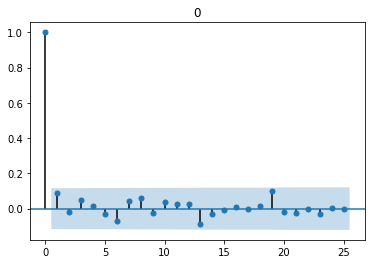

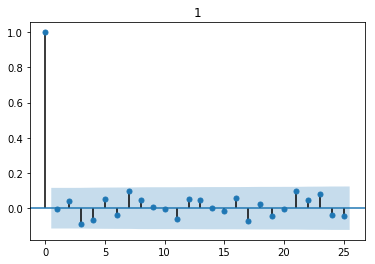

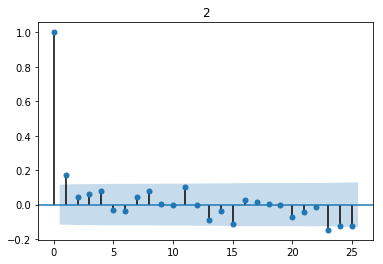

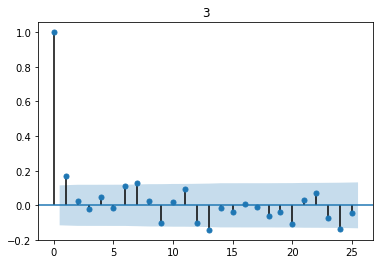

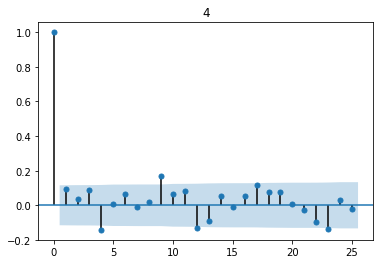

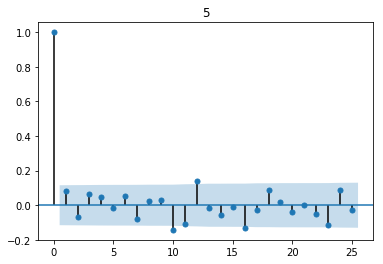

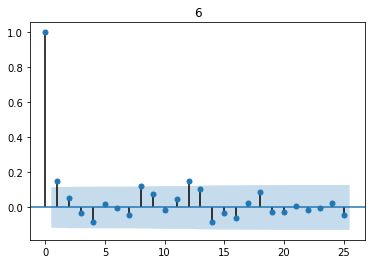

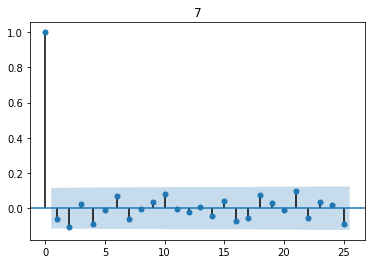

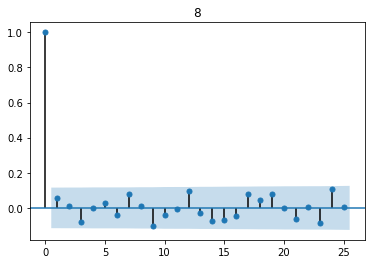

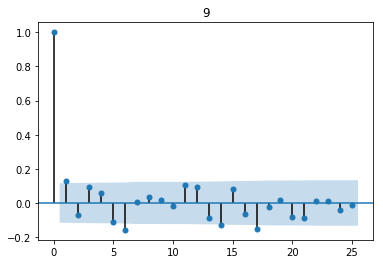

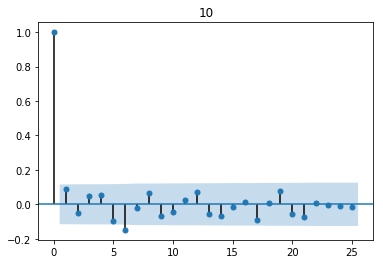

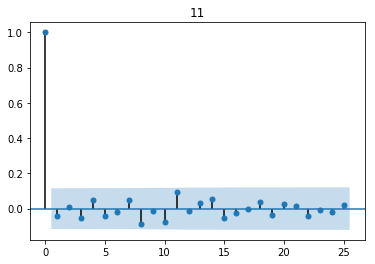

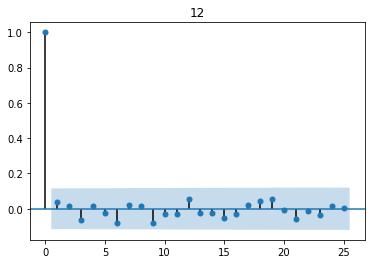

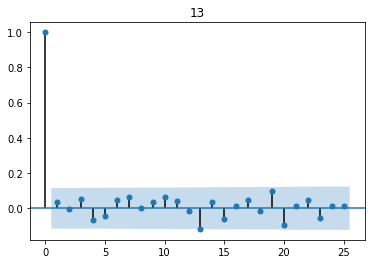

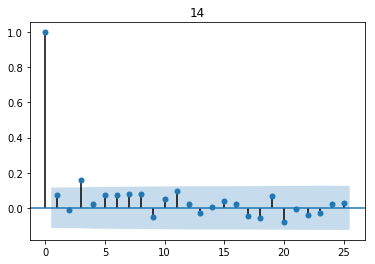

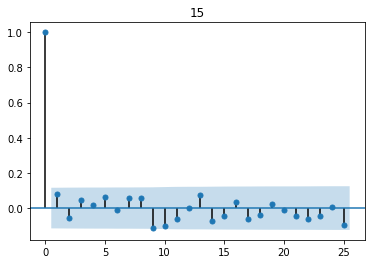

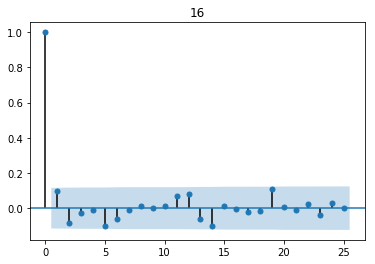

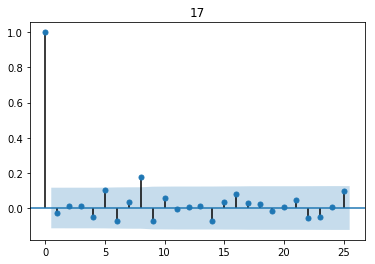

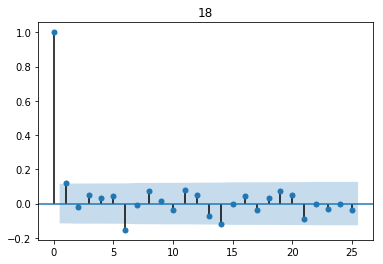

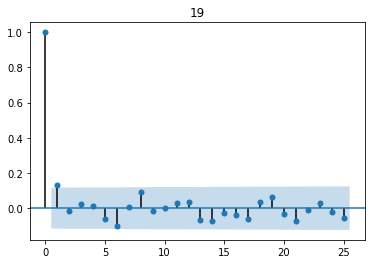

In [22]:
#ACF for all factors
for i in range(20):
    plot_acf(factors.iloc[:,i])
    plt.title(i)
    plt.show()

## Calculating weights based on selected factors with Ridge

In [23]:
# 1. fit return regressions on factors chosen with chosen model: get betas and alpha
# 2. only include chosen subfactors
# 3. forecast expected factor returns for the test set
# 4. forecast covariance for each month of test set of each stock
# 5. calculate weights using forecasted expected returns and covariance for next month
# 6. apply this months weights on next month returns in the test set, calculate total portfolio return
# 7. plot NAV

#matrices we need: expected returns, residuals, weights, covariance matrix for factors 

#1 including only chosen subfactors
X_train = X_train[['mktrf','smb','hml','mom','money','manuf','utils','shops','other']]
X_test = X_test[['mktrf','smb','hml','mom','money','manuf','utils','shops','other']]
#durbl, enrgy, rmw, buseq

#regression fit
ridge_alpha = 0.316
#lasso alpha = 0.006
coefs=[range(1,X_train.shape[1]+1)]
intercept = []
coefs=np.array(coefs).reshape(-1,1)
resids_train = [range(1, (len(X_train)+1))]
resids_train=np.array(resids_train).reshape(-1,1)
resids_test = [range(1, (len(X_test)+1))]
resids_test=np.array(resids_test).reshape(-1,1)

for r in range(500):
    Y=Y_train.iloc[:,r:(r+1)]
    Y=np.array(Y)
    ridge = Ridge(alpha=ridge_alpha)
    ridge.fit(X_train,Y) 
    coefs=np.hstack((coefs, ridge.coef_.reshape(-1,1)))
    intercept.append(ridge.intercept_)
    resids_train = np.hstack((resids_train,ridge.predict(X_train).reshape(-1,1))) 
    resids_test = np.hstack((resids_test,ridge.predict(X_test).reshape(-1,1)))

In [24]:
print X_train.shape, X_test.shape

(201, 9) (87, 9)


In [25]:
coefs = pd.DataFrame(coefs).iloc[:,1:]
coefs.shape

(9, 500)

In [26]:
# 3. forecast expected factor returns for the test set
fact_pred=[range(1,(len(X_test)+1))]
fact_pred=np.array(fact_pred).reshape(-1,1)

for i in range(X_test.shape[1]):
    mean_list=[]
    for j in range(X_test.shape[0]):
        mean=X_test.iloc[0:j,i].mean()
        mean_list.append(mean)
    fact_pred=np.hstack((fact_pred, np.array(mean_list).reshape(-1,1)))
fact_pred = pd.DataFrame(fact_pred).iloc[:,1:]

In [27]:
# 4. forecast covariance for each month of test set of each stock
fact_pred_test = fact_pred
# initialize the mean from the training set
fact_pred_test.iloc[0,:] = np.array(np.mean(X_train))
fact_pred_test.columns = X_train.columns


In [28]:
#merge with training dataset
fact_for_cov = X_train
fact_for_cov = fact_for_cov.append(fact_pred_test, ignore_index = True)

In [29]:
cov_mat = []
for i in range(X_test.shape[0]):
    cov_mat.append(np.cov(fact_for_cov.iloc[:(cutoff+i),:].T))

In [30]:
#checking the dimension of the covariance matrix for factors
np.array(cov_mat)[0].shape

(9, 9)

In [31]:
coefs=coefs.to_numpy()
coefs=coefs.T
coefs.shape

(500, 9)

In [32]:
cov_beta_factors=[range(1, (len(X_test)+1))]
cov_beta_factors=np.array(cov_beta_factors).reshape(-1,1)

for i in range(500):
    cov_fi=[]
    for j in range(len(X_test)):
        c=coefs[i].reshape(-1,1).T.dot(np.array(cov_mat)[j]).dot(coefs[i].reshape(-1,1))
        cov_fi.append(c)
    cov_beta_factors=np.hstack((cov_beta_factors, np.array(cov_fi).reshape(-1,1)))        

In [33]:
#covariance matrix for every factor for every month in test set without residuals
cov_beta_factors=pd.DataFrame(cov_beta_factors).iloc[:,1:]

In [34]:
#expected return forecasts based on betas and alphas for test set
exp_rets=[range(1, (len(X_test)+1))]
exp_rets=np.array(exp_rets).reshape(-1,1)

for i in range(500):
    pred_ret=[]
    for j in range(len(X_test)):
        p=coefs[i].dot(np.array(X_test)[j]) + intercept[i]
        pred_ret.append(p)
    exp_rets=np.hstack((exp_rets, np.array(pred_ret).reshape(-1,1)))        

In [35]:
# predicted returns matrix for test set
exp_rets=pd.DataFrame(exp_rets).iloc[:,1:]

In [36]:
#calculating residuals on training set
resids_train = pd.DataFrame(resids_train).iloc[:,1:]
resids_test = pd.DataFrame(resids_test).iloc[:,1:]
resids = resids_train.append(resids_test, ignore_index = True)

In [37]:
#variance of residuals
exp_res=[range(1, (len(X_test)+1))]
exp_res=np.array(exp_res).reshape(-1,1)

for i in range(500):
    res_var=[]
    for j in range(len(X_test)):
        v= np.var(np.array(resids.iloc[:,i])[:X_train.shape[0] + j])
        res_var.append(v)
    exp_res=np.hstack((exp_res, np.array(res_var).reshape(-1,1)))        

In [38]:
exp_res=pd.DataFrame(exp_res).iloc[:,1:]

In [39]:
#covariance of returns for test set
cov_rets = exp_res+cov_beta_factors

In [40]:
# 5. calculate weights using forecasted expected returns and covariance for next month
#exp_rets, cov_rets
exp_rets.shape

(87, 500)

In [41]:
#weights for each stock
weights = exp_rets/(cov_rets) #does not depend on risk aversion

In [42]:
weights['sum_w'] = weights.apply(np.sum,axis = 1)

In [43]:
#normalizing weights to sum to 1
weights = weights.iloc[:,:500].div(weights.sum_w, axis=0)

In [44]:
# 6. apply this months weights on next month returns in the test set, calculate total portfolio return
weights = weights.shift(1).iloc[:X_test.shape[0],:]

In [54]:
port_rets = pd.DataFrame(weights.values*Y_test.values, columns=Y_test.columns, index=Y_test.index).apply(np.sum,axis = 1)
rf_tst = risk_free.iloc[cutoff:]
port_rets = port_rets.add(rf_tst, axis= 'index')
cum_port_rets = np.cumprod(1+port_rets)

/Users/elinaharutyunyan/opt/anaconda2/lib/python2.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


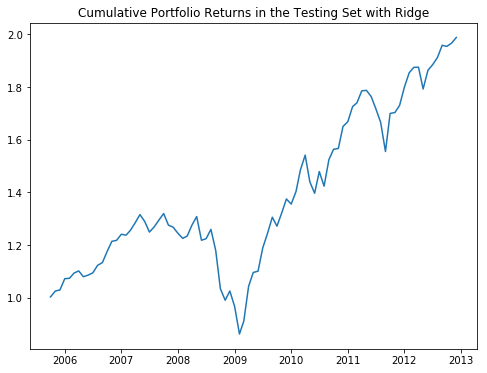

In [55]:
plt.figure(figsize=(8,6))
plt.plot(cum_port_rets)
plt.title("Cumulative Portfolio Returns in the Testing Set with Ridge")
plt.show()

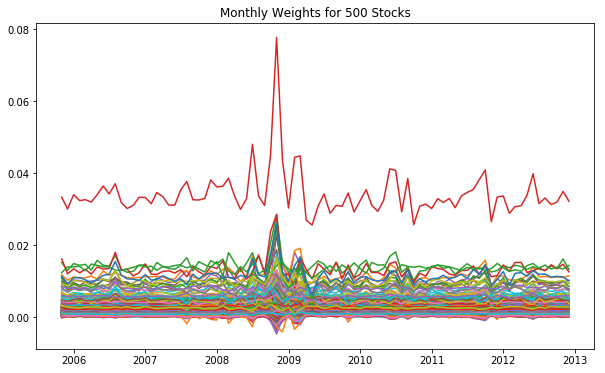

In [56]:
plt.figure(figsize=(10,6))
plt.plot(Y_test.index[1:],weights.iloc[1:,:])
plt.title("Monthly Weights for 500 Stocks")
plt.show()

In [57]:
#performance of the model
np.mean(port_rets) - 5*np.var(port_rets)

0.0006391864037815255

## Calculating weights based on selected factors with Lasso

In [58]:
#regression fit
lasso_alpha = 0.008
coefs=[range(1,X_train.shape[1]+1)]
intercept = []
coefs=np.array(coefs).reshape(-1,1)
resids_train = [range(1, (len(X_train)+1))]
resids_train=np.array(resids_train).reshape(-1,1)
resids_test = [range(1, (len(X_test)+1))]
resids_test=np.array(resids_test).reshape(-1,1)

for r in range(500):
    Y=Y_train.iloc[:,r:(r+1)]
    Y=np.array(Y)
    lasso = Lasso(alpha=lasso_alpha)
    lasso.fit(X_train,Y) 
    coefs=np.hstack((coefs, lasso.coef_.reshape(-1,1)))
    intercept.append(lasso.intercept_)
    resids_train = np.hstack((resids_train,lasso.predict(X_train).reshape(-1,1))) 
    resids_test = np.hstack((resids_test,lasso.predict(X_test).reshape(-1,1)))

In [59]:
coefs = pd.DataFrame(coefs).iloc[:,1:]
coefs.shape

(20, 500)

In [60]:
# 3. forecast expected factor returns for the test set
fact_pred=[range(1,(len(X_test)+1))]
fact_pred=np.array(fact_pred).reshape(-1,1)

for i in range(X_test.shape[1]):
    mean_list=[]
    for j in range(X_test.shape[0]):
        mean=X_test.iloc[0:j,i].mean()
        mean_list.append(mean)
    fact_pred=np.hstack((fact_pred, np.array(mean_list).reshape(-1,1)))
fact_pred = pd.DataFrame(fact_pred).iloc[:,1:]

In [61]:
# 4. forecast covariance for each month of test set of each stock
fact_pred_test = fact_pred
# initialize the mean from the training set
fact_pred_test.iloc[0,:] = np.array(np.mean(X_train))
fact_pred_test.columns = X_train.columns

In [62]:
#merge with training dataset
fact_for_cov = X_train
fact_for_cov = fact_for_cov.append(fact_pred_test, ignore_index = True)

In [63]:
cov_mat = []
for i in range(X_test.shape[0]):
    cov_mat.append(np.cov(fact_for_cov.iloc[:(cutoff+i),:].T))

In [64]:
#checking the dimension of the covariance matrix for factors
np.array(cov_mat)[0].shape

(20, 20)

In [65]:
coefs=coefs.to_numpy()
coefs=coefs.T
coefs.shape

(500, 20)

In [66]:
cov_beta_factors=[range(1, (len(X_test)+1))]
cov_beta_factors=np.array(cov_beta_factors).reshape(-1,1)

for i in range(500):
    cov_fi=[]
    for j in range(len(X_test)):
        c=coefs[i].reshape(-1,1).T.dot(np.array(cov_mat)[j]).dot(coefs[i].reshape(-1,1))
        cov_fi.append(c)
    cov_beta_factors=np.hstack((cov_beta_factors, np.array(cov_fi).reshape(-1,1)))        

In [67]:
#covariance matrix for every factor for every month in test set without residuals
cov_beta_factors=pd.DataFrame(cov_beta_factors).iloc[:,1:]

In [68]:
#expected return forecasts based on betas and alphas for test set
exp_rets=[range(1, (len(X_test)+1))]
exp_rets=np.array(exp_rets).reshape(-1,1)

for i in range(500):
    pred_ret=[]
    for j in range(len(X_test)):
        p=coefs[i].dot(np.array(X_test)[j]) + intercept[i]
        pred_ret.append(p)
    exp_rets=np.hstack((exp_rets, np.array(pred_ret).reshape(-1,1)))        

In [69]:
# predicted returns matrix for test set
exp_rets=pd.DataFrame(exp_rets).iloc[:,1:]

In [70]:
#calculating residuals on training set
resids_train = pd.DataFrame(resids_train).iloc[:,1:]
resids_test = pd.DataFrame(resids_test).iloc[:,1:]
resids = resids_train.append(resids_test, ignore_index = True)

In [71]:
#variance of residuals
exp_res=[range(1, (len(X_test)+1))]
exp_res=np.array(exp_res).reshape(-1,1)

for i in range(500):
    res_var=[]
    for j in range(len(X_test)):
        v= np.var(np.array(resids.iloc[:,i])[:X_train.shape[0] + j])
        res_var.append(v)
    exp_res=np.hstack((exp_res, np.array(res_var).reshape(-1,1)))        

In [72]:
exp_res=pd.DataFrame(exp_res).iloc[:,1:]

In [73]:
#covariance of returns for test set
cov_rets = exp_res+cov_beta_factors

In [74]:
#weights for each stock
weights = exp_rets/(cov_rets) #does not depend on risk aversion

In [75]:
weights['sum_w'] = weights.apply(np.sum,axis = 1)
#normalizing weights to sum to 1
weights = weights.iloc[:,:500].div(weights.sum_w, axis=0)

In [76]:
# 6. apply this months weights on next month returns in the test set, calculate total portfolio return
weights = weights.shift(1).iloc[:X_test.shape[0],:]

In [78]:
port_rets = pd.DataFrame(weights.values*Y_test.values, columns=Y_test.columns, index=Y_test.index).apply(np.sum,axis = 1)
rf_tst = risk_free.iloc[cutoff:]
port_rets = port_rets.add(rf_tst, axis= 'index')
cum_port_rets = np.cumprod(1+port_rets)

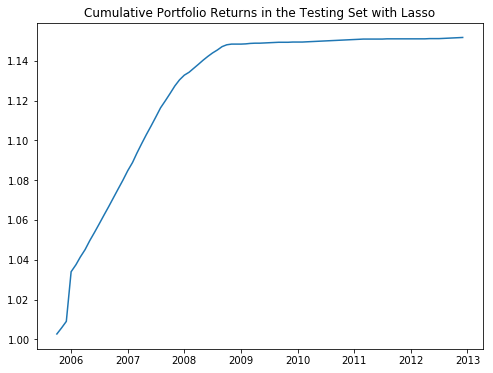

In [79]:
plt.figure(figsize=(8,6))
plt.plot(cum_port_rets)
plt.title("Cumulative Portfolio Returns in the Testing Set with Lasso")
plt.show()

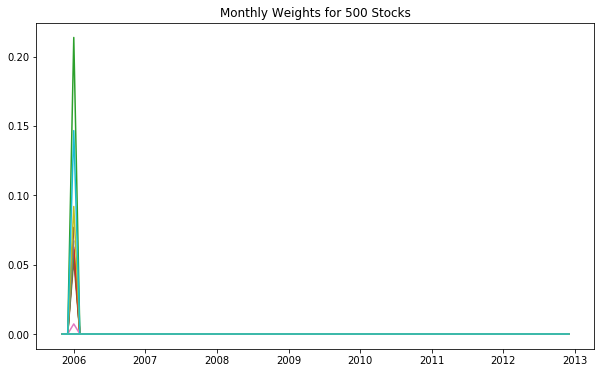

In [80]:
plt.figure(figsize=(10,6))
plt.plot(Y_test.index[1:],weights.iloc[1:,:])
plt.title("Monthly Weights for 500 Stocks")
plt.show()

In [81]:
#performance of the model
np.mean(port_rets) - 5*np.var(port_rets)

0.0015839414568790424